In [88]:

from __future__ import absolute_import, division, print_function, unicode_literals
import os
import mne
from mne.io import read_raw_edf
from mne import concatenate_raws, read_annotations
import numpy as np
import glob
from tqdm.notebook import tqdm
import random
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn.preprocessing import minmax_scale 


import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback


In [4]:
load_from_file = True
epi_num = 30
no_epi_num = 30

Se insertan los nombres de los canales que hay en todo el dataset para controlar cuales faltan en cada muestra

In [5]:
channel_names = ['EEG FP1-REF', 
                 'EEG FP2-REF',
                 'EEG F3-REF',
                 'EEG F4-REF',
                 'EEG C3-REF',
                 'EEG C4-REF',
                 'EEG P3-REF',
                 'EEG P4-REF',
                 'EEG O1-REF',
                 'EEG O2-REF',
                 'EEG F7-REF',
                 'EEG F8-REF',
                 'EEG T3-REF',
                 'EEG T4-REF',
                 'EEG T5-REF',
                 'EEG T6-REF',
                 'EEG T1-REF',
                 'EEG T2-REF',
                 'EEG FZ-REF',
                 'EEG CZ-REF',
                 'EEG PZ-REF',
                 'EEG EKG1-REF',
                 'EEG PG1-REF',
                 'EEG PG2-REF',
                 'EEG C3P-REF',
                 'EEG C4P-REF',
                 'EEG SP1-REF',
                 'EEG SP2-REF',
                 'EMG-REF',
                 'EEG ROC-REF',
                 'EEG LOC-REF',
                 'PHOTIC-REF',
                 'EEG A1-REF',
                 'EEG A2-REF', 
                 'EEG 26-REF',
                 'EEG 27-REF',
                 'EEG 28-REF',
                 'EEG 29-REF',
                 'EEG 30-REF',
                 'EEG 31-REF',
                 'EEG 32-REF',
                 'IBI',
                 'BURSTS',
                 'SUPPR']

In [6]:
def load_data(from_file = False, fname = "data.npz"):
    print("Building dataset from scratch...")
    #Directorio base donde se encuentra el dataset
    base_path = "C:\\Users\\Ceiec01\\OneDrive - UFV\\datasets\\TUH Epilepsy"
    #Version del dataset seleccionado
    version = "v1.0.0"
    #Semilla para reproducibilidad
    random.seed(42)

    epi_path = os.path.join(base_path, version, 'edf', 'epilepsy')
    no_epi_path = os.path.join(base_path, version, 'edf', 'no_epilepsy')
    #Cogemos los ficheros edf tanto de epilepsia como de no epilepsia
    epi_files = glob.glob(epi_path + '\\01_tcp_ar\\**\\*.edf', recursive=True)
    no_epi_files = glob.glob(no_epi_path + '\\01_tcp_ar\\**\\*.edf', recursive=True)

    if not from_file:
        #Seleccionamos 30 al azar de cada dataset
        epi_files = np.asarray(random.sample(epi_files, epi_num))
        no_epi_files = np.asarray(random.sample(no_epi_files, no_epi_num))
        np.savez(fname, epi_files, no_epi_files)
    else:
        npzfile = np.load(fname)
        epi_files = npzfile['arr_0']
        no_epi_files = npzfile['arr_1']

    #Leemos los raw de todos ellos
    epi_raws = [read_raw_edf(f, verbose = False) for f in epi_files]
    no_epi_raws = [read_raw_edf(f, verbose = False) for f in no_epi_files]

    data = [] #List to hold all the data
    minimo = 1250 #Sortest len to cut EEGs (measured from the dataset)

    #Cargar datos de epilepsia
    for i in tqdm(range(len(epi_raws)), desc = 'Loading epilepsy'):
        #Select one raw file
        epi_data = epi_raws[i].get_data()
        #Get EEG recorded lenght
        size = epi_data.shape[1]
        #Create an array of zeros (Final_channel_number, size)
        new_epi = np.zeros((len(channel_names),size))
        #Check which channels are present and copy them in the respective position
        for j in range(len(epi_raws[i].ch_names)):
            new_epi[channel_names.index(epi_raws[i].ch_names[j])] = epi_data[j]
        #Copy that back, with missing channels filled with zeros
        epi_data = new_epi
        #Crop EEGs to minimo size and discard the last part if it doesn't fit
        if size%minimo == 0:
            epi_split = np.split(epi_data, size//minimo, axis = 1)
        else:
            epi_split = np.split(epi_data[:,:-(size%minimo)], size//minimo, axis = 1)
        #Put all the pieces into data
        data.extend(epi_split)
    #Count how many epilepsy there were to put tags later
    num_epi = len(data)

    #Cargamos los datos de no epilepsia
    for i in tqdm(range(len(no_epi_raws)), desc = 'Loading non-epilepsy'):
        #Select one raw file
        no_epi_data = no_epi_raws[i].get_data()
        #Get EEG recorded lenght
        size = no_epi_data.shape[1]
        #Create an array of zeros (Final_channel_number, size)
        new_no_epi = np.zeros((len(channel_names),size))
        #Check which channels are present and copy them in the respective position
        for j in range(len(no_epi_raws[i].ch_names)):
            new_no_epi[channel_names.index(no_epi_raws[i].ch_names[j])] = no_epi_data[j]
        #Copy that back, with missing channels filled with zeros
        no_epi_data = new_no_epi  
        #Crop EEGs to minimo size and discard the last part if it doesn't fit
        if size%minimo == 0:
            no_epi_split = np.split(no_epi_data, size//minimo, axis = 1)
        else:
            no_epi_split = np.split(no_epi_data[:,:-(size%minimo)], size//minimo, axis = 1)
        #Put all the pieces into data
        data.extend(no_epi_split)
    #Count how many epilepsy there were to put tags later
    num_no_epi = len(data) - num_epi
    print(len(data))
    print(data[0].shape)
    dataframe = pd.DataFrame({'Datos': data, 'Tag': np.append(np.ones(num_epi), np.zeros(num_no_epi))})

    return dataframe

In [7]:
dataset = load_data(load_from_file)

Building dataset from scratch...



11698
(44, 1250)


Creating RawArray with float64 data, n_channels=44, n_times=1250
    Range : 0 ... 1249 =      0.000 ...     1.249 secs
Ready.


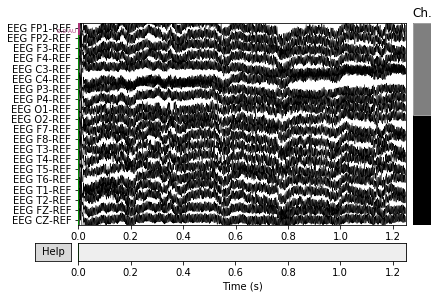

In [8]:
mne.io.RawArray(dataset.Datos[0], mne.create_info(channel_names, 1000)).plot()
plt.show()

In [93]:
# Creamos la clase que recibe un Callback, nos permite parar el entrenamiento cuando una medida baje de un valor concreto
class EarlyStoppingByLoss(Callback):
    # Llamada de la inicialización de la función (Verbose está, pero deshabilitado)
    def __init__(self, monitor='loss', value=0.2, verbose=1):
        # Llamamos al padre para sobrecargar métodos
        super(Callback, self).__init__()
        #Establecemos los valores para que sean los parámetros
        self.monitor = monitor
        self.value = value
        self.verbose = verbose
    # Esta función se ejecuta cuando termina una época
    def on_epoch_end(self, epoch, logs={}):
        # Miramos en el log cuanto ha sido el valor que estamos monitorizando
        current = logs.get(self.monitor)
        # Si es menor
        if current <= self.value:
            # que pare el entrenamiento y nos de el feedback
            self.model.stop_training = True
            print("La red ha finalizado el entrenamiento debido al criterio de parada establecido")

# **Baseline**

In [9]:
msk = np.random.rand(len(dataset)) < 0.8

train = dataset[msk]
test = dataset[~msk]

In [10]:
print(len(dataset))
print(len(test))
print(len(train))

11698
2442
9256


In [89]:

def prep_data(in_data):
    #Guardamos el número de imágenes que se nos pasan por parámetros
    count = len(in_data)
    #Inicializamos un array vacío para guardar las imágenes
    data = np.ndarray((count, 1, in_data.iloc[0].shape[0], in_data.iloc[0].shape[1]), dtype=np.uint8)
    #Recorremos las rutas de las imágenes
    for i in tqdm(range(0,len(in_data))):
        preprocessed = minmax_scale(in_data.iloc[i].tolist())
        data[i] = np.reshape(preprocessed, (1, in_data.iloc[0].shape[0], in_data.iloc[0].shape[1]))
    return data

In [90]:
im_bs_train = prep_data(train.Datos)
im_bs_test = prep_data(test.Datos)

In [101]:
mean_baseline_train = np.mean(im_bs_train, axis=2)
max_baseline_train =  np.max(im_bs_train, axis=2)
mean_baseline_test =  np.mean(im_bs_test, axis=2)
max_baseline_test =   np.max(im_bs_test, axis=2)


#VLAEEG no es un método aceptable de momento #vlaeeg_normed_data, vlaeeg_data = vlaeeg(data, 10, 'l2', True)

In [105]:
model1 =  tf.keras.Sequential()

model1.add(layers.LSTM(128, activation = 'relu', return_sequences=True, input_shape=(1,1250)))
model1.add(layers.BatchNormalization())
model1.add(layers.Dropout(0.2))
model1.add(layers.LSTM(128, activation = 'relu', return_sequences=True))
model1.add(layers.BatchNormalization())
model1.add(layers.Dropout(0.2))

model1.add(layers.Dense(32, activation='relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.Dropout(0.2))
model1.add(layers.Dense(1, activation='sigmoid'))


model1.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['binary_accuracy'])

In [106]:
model2 =  tf.keras.Sequential()
model2.add(layers.Dense(128, activation = 'relu', input_shape=(1,1250)))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(128, activation = 'relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(0.2))

model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(1, activation='sigmoid'))


model2.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['binary_accuracy'])

In [107]:
logdir = "logs\\mean\\" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
modelcallback = keras.callbacks.ModelCheckpoint('checkpoints/weights.mean.{epoch:02d}-{val_loss:.2f}.hdf5')
valloss = EarlyStoppingByLoss(monitor='loss', value = 0.2, verbose=1)

model2.fit(mean_baseline_train, 
          train.Tag.values,
          validation_data=(mean_baseline_test,test.Tag.values),
          epochs=100,
          callbacks = [tensorboard_callback,
                       modelcallback,
                      valloss])

Train on 9256 samples, validate on 2442 samples
Epoch 1/100
9256/9256 [==============================] - ETA: 5:58 - loss: 0.8234 - binary_accuracy: 0.437 - ETA: 3:06 - loss: 0.9127 - binary_accuracy: 0.484 - ETA: 42s - loss: 0.9352 - binary_accuracy: 0.461 - ETA: 23s - loss: 0.9120 - binary_accuracy: 0.46 - ETA: 16s - loss: 0.8925 - binary_accuracy: 0.48 - ETA: 13s - loss: 0.8896 - binary_accuracy: 0.48 - ETA: 11s - loss: 0.8810 - binary_accuracy: 0.49 - ETA: 9s - loss: 0.8704 - binary_accuracy: 0.5022 - ETA: 8s - loss: 0.8677 - binary_accuracy: 0.501 - ETA: 7s - loss: 0.8642 - binary_accuracy: 0.497 - ETA: 6s - loss: 0.8622 - binary_accuracy: 0.501 - ETA: 6s - loss: 0.8592 - binary_accuracy: 0.502 - ETA: 5s - loss: 0.8596 - binary_accuracy: 0.501 - ETA: 5s - loss: 0.8564 - binary_accuracy: 0.500 - ETA: 4s - loss: 0.8537 - binary_accuracy: 0.502 - ETA: 4s - loss: 0.8540 - binary_accuracy: 0.502 - ETA: 4s - loss: 0.8510 - binary_accuracy: 0.503 - ETA: 3s - loss: 0.8503 - binary_accurac

KeyError: 'val_loss'

In [108]:
logdir = "logs\\max\\" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
modelcallback = keras.callbacks.ModelCheckpoint('checkpoints/weights.mean.{epoch:02d}-{val_loss:.2f}.hdf5')
valloss = EarlyStoppingByLoss(monitor='loss', value = 0.2, verbose=1)


model1.fit(max_baseline_train, 
          train.Tag.values,
          validation_data=(max_baseline_test,test.Tag.values),
          epochs=100,
          callbacks = [tensorboard_callback,
                       modelcallback,
                       valloss])

Train on 9256 samples, validate on 2442 samples
Epoch 1/100
9256/9256 [==============================] - ETA: 12:15 - loss: 1.0781 - binary_accuracy: 0.43 - ETA: 6:18 - loss: 0.9703 - binary_accuracy: 0.4688 - ETA: 2:07 - loss: 0.8536 - binary_accuracy: 0.531 - ETA: 1:25 - loss: 0.8684 - binary_accuracy: 0.520 - ETA: 55s - loss: 0.8474 - binary_accuracy: 0.529 - ETA: 40s - loss: 0.8397 - binary_accuracy: 0.53 - ETA: 32s - loss: 0.8494 - binary_accuracy: 0.51 - ETA: 26s - loss: 0.8550 - binary_accuracy: 0.51 - ETA: 22s - loss: 0.8506 - binary_accuracy: 0.51 - ETA: 19s - loss: 0.8395 - binary_accuracy: 0.51 - ETA: 17s - loss: 0.8368 - binary_accuracy: 0.51 - ETA: 15s - loss: 0.8321 - binary_accuracy: 0.51 - ETA: 13s - loss: 0.8294 - binary_accuracy: 0.50 - ETA: 12s - loss: 0.8249 - binary_accuracy: 0.50 - ETA: 11s - loss: 0.8238 - binary_accuracy: 0.50 - ETA: 10s - loss: 0.8213 - binary_accuracy: 0.50 - ETA: 9s - loss: 0.8212 - binary_accuracy: 0.5037 - ETA: 8s - loss: 0.8193 - binary_ac

KeyError: 'val_loss'

Se va a realizar una CNN como baseline del modelo.

In [91]:
im_bs_train.shape

(9256, 1, 44, 1250)

In [92]:
model = Sequential()

# Añadimos capas de convolucion 2D con diferentes numeros de filtros y el tamaño de los mismos a 3x3
model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding="same", input_shape=(1, 44, 1250), activation="relu"))
model.add(Conv2D(filters = 32,kernel_size = (3, 3), padding="same", activation="relu"))
model.add(Conv2D(filters = 32,kernel_size = (3, 3), padding="same", activation="relu"))
# Capa de pooling que se encarga de reducir la dimensión manteniendo las características esenciales de la red.
model.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_first"))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64,kernel_size = (3, 3), padding="same", activation="relu"))
model.add(Conv2D(filters = 64,kernel_size = (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128,kernel_size = (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_first"))
model.add(Dropout(0.2))

model.add(Conv2D(filters =256, kernel_size = (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_first"))
model.add(Dropout(0.2))

# MLP para clasificar las salidas de la CNN asignando una probabilidad a cada una de las etiquetas
# Pasamos la red de dos dimensiones a una única dimensión para realizar la clasificación de las características extraídas.
model.add(Flatten())
# Añadimos una capa de oculta de 1024 neuronas con la función de activación ReLU.
model.add(Dense(1024, activation="relu"))
# Realizamos un dropout de algunas de las neuronas de la capa con una probabilidad del 50% para evitar el overfitting de la red.
model.add(Dropout(0.5)) 
# Añadimos una capa de oculta de 512 neuronas con la función de activación ReLU.
model.add(Dense(512, activation="relu"))
# Realizamos un dropout de algunas de las neuronas de la capa con una probabilidad del 50% para evitar el overfitting de la red.
model.add(Dropout(0.5))
# Añadimos una capa de salida de 10 neuronas (número de etiquetas correspondientes a las conductas) con la función de activación Softmax.
model.add(Dense(1, activation = "sigmoid"))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [94]:
logdir = "logs\\CNN\\" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
modelcallback = keras.callbacks.ModelCheckpoint('checkpoints/weights.mean.{epoch:02d}-{val_loss:.2f}.hdf5')
valloss = EarlyStoppingByLoss(monitor='loss', value = 0.2, verbose=1)


fit = model.fit(im_bs_train, 
          train.Tag.values,
          validation_data=(im_bs_test,test.Tag.values),
          epochs=100,
          callbacks = [tensorboard_callback,
                       modelcallback,
                       valloss])

Train on 9256 samples, validate on 2442 samples
Epoch 1/100
9256/9256 [==============================] - ETA: 3:41 - loss: 0.6930 - accuracy: 0.68 - ETA: 1:59 - loss: 0.6922 - accuracy: 0.64 - ETA: 27s - loss: 0.6919 - accuracy: 0.5799 - ETA: 15s - loss: 0.6678 - accuracy: 0.588 - ETA: 11s - loss: 0.6540 - accuracy: 0.577 - ETA: 9s - loss: 0.6254 - accuracy: 0.578 - ETA: 8s - loss: 0.6134 - accuracy: 0.58 - ETA: 7s - loss: 0.5947 - accuracy: 0.61 - ETA: 6s - loss: 0.5741 - accuracy: 0.63 - ETA: 5s - loss: 0.5574 - accuracy: 0.65 - ETA: 5s - loss: 0.5469 - accuracy: 0.66 - ETA: 4s - loss: 0.5331 - accuracy: 0.68 - ETA: 4s - loss: 0.5215 - accuracy: 0.69 - ETA: 3s - loss: 0.5128 - accuracy: 0.70 - ETA: 3s - loss: 0.5056 - accuracy: 0.70 - ETA: 3s - loss: 0.4959 - accuracy: 0.71 - ETA: 2s - loss: 0.4885 - accuracy: 0.72 - ETA: 2s - loss: 0.4810 - accuracy: 0.72 - ETA: 2s - loss: 0.4785 - accuracy: 0.73 - ETA: 2s - loss: 0.4751 - accuracy: 0.73 - ETA: 2s - loss: 0.4736 - accuracy: 0.73 - E

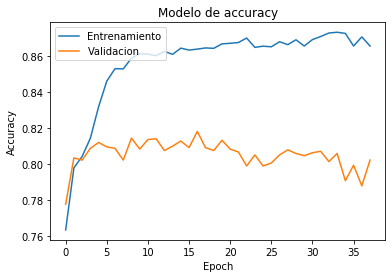

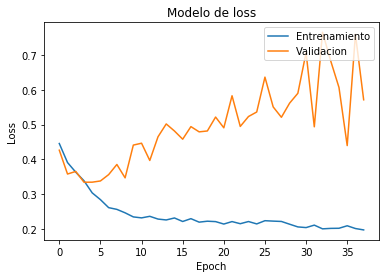

In [97]:
# Pintamos los valores de 'loss' y 'accuracy' tanto para el conjunto de entrenamiento como el de validación.
plt.plot(fit.history['accuracy'])
plt.plot(fit.history['val_accuracy'])
plt.title('Modelo de accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Entrenamiento', 'Validacion'], loc='upper left')
plt.show()
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.title('Modelo de loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Entrenamiento', 'Validacion'], loc='upper right')
plt.show()

In [100]:
np.mean(im_bs_train, axis=2).shape

(9256, 1, 1250)